In [4]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
%matplotlib inline

In [5]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [30]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"

color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'purple',
                'sdss_g':    'darkgreen','ptf_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'r', "sdss_r'":    'r',
                'sdss_z':    'brown', "sdss_z'":    'brown',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o',
              'Bessell_B': 'o',
                'Bessell_V':  'o',
                'Bessell_R':  'o',
                'Bessell_I':  'o',
                'sdss_g':'s','ptf_g':'s', "sdss_g'":'s',
                'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s',
                'sdss_z':'s', "sdss_z'":'s',
                'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o',
              'Ks':  'o','K':  'o',
                'swift_UVW1':'D',
                'swift_UVW2':'D',
                'swift_UVM2':'D',
                'swift_U':'D',
                'swift_V':'D',
                'swift_B':'D'}

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

In [31]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [32]:
def calc_lam_avg(wls, transmission):
    return (integrate.trapz(transmission*wls, wls)/\
            integrate.trapz(transmission, wls))

def calc_lam_eff(wls, transmission, flux):
    return (integrate.trapz(transmission*flux*wls, wls)/\
            integrate.trapz(transmission*flux, wls))


def prop_err_div(x,y,sig_x,sig_y):
    return ((sig_x/y)**2  +  ((x*sig_y)/y**2)**2 )**0.5

In [48]:
class SingleSpectrumClass():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, main_path, snname, spec_file=None, verbose=False):
        """
        """
        if verbose: print ('MAIN PATH', main_path)
        ## Initialise the class variables            
        self.main_path = main_path
        self.lc_data_path = main_path+'lc/'
        self.fitted_data_path = main_path+'lc/'
        self.spec_data_path = main_path+'spec_smoothed/'
        self.snname = snname
        self.check_results_folder()
        
        if spec_file is None:
            print ("Choose one spec_file from this list:")
            print (len(self.get_spec_list()))
        else:
            self.spec_file = spec_file
            print ('self.spec_file', self.spec_file.replace(main_path, ''))
            self.load_manglingfile()

    def check_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/'%self.snname
        if not os.path.exists(results_directory):
            print ("I cant mangle a spectrum if I theres no fitted LC yet")
        else: self.results_mainpath = results_directory

    def load_manglingfile(self):
        if not hasattr(self, "results_mainpath"):
            self.check_results_folder()
        else:
            mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
            if not os.path.isfile(mangling_file):
                print ("I need the file with fitted photometry in order to mangle a spectrum")
            else:
                phot4mangling = pd.read_csv(mangling_file, sep='\t')
                #print (phot4mangling)#self.phot4mangling = 
                self.phot4mangling = (phot4mangling[phot4mangling['spec_file']== self.spec_file])
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                
    def load_raw_spec(self):
        if not hasattr(self, "phot4mangling"):
            self.load_manglingfile()
        else:
            raw_spec = np.genfromtxt(self.spec_file,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'fluxerr'])
            raw_spec = raw_spec[(~np.isnan(raw_spec['flux']))&(~np.isnan(raw_spec['wls']))]
            raw_spec['flux'] = raw_spec['flux']
            self.raw_spec = raw_spec
        return raw_spec
        
    def get_spec_list(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            spec_list = parse_phase['f2']
            mjd_list = parse_phase['f0']
            mjd_fake_phase = parse_phase['f1']
            if verbose: 
                for mjd,i in zip(spec_list, mjd_list): 
                    print (mjd, i)
            return np.array(spec_list)
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
  
    def check_spec_manglingphot(self):
        all_specs = self.get_spec_list()
        mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
        phot4mangling = pd.read_csv(mangling_file, sep='\t')
        for spec_file in all_specs:
            file_name = spec_file
            mask = phot4mangling['spec_file'].values == file_name
            if len(phot4mangling[mask])==0:
                print ('There.s no magnling photometry fro this. Are you sure nothing went wrong?', spec_file)

    def create_mangledspec_folder(self):
        mangledspec_directory = self.main_path+'/results_template/%s/mangled_spectra/'%self.snname
        if not os.path.exists(mangledspec_directory):
            os.makedirs(mangledspec_directory)
        self.mangledspec_path = mangledspec_directory

    
    def band_flux(self, filter_name, type_spec2use=False):
        """ type_spec2use choose one among: 
                raw_spec, 
                mangled  """
        
        if (not hasattr(self, 'raw_spec'))&(type_spec2use=='raw_spec'):
            print ("Load the spectrum first calling self.load_raw_spec() and self.break_degeneracy()")
        elif (hasattr(self, 'raw_spec'))&(type_spec2use=='raw_spec'):
              spec_flux = self.raw_spec
        elif (not hasattr(self, 'mangled_spec'))&(type_spec2use=='mangled'):
            print ("Mangled spectrum not available. Mangle the spectrum first calling self.mangle_spectrum()")
        elif (hasattr(self, 'mangled_spec'))&(type_spec2use=='mangled'):
              spec_flux = self.mangled_spec
        
        #print ('type_spec2use', type_spec2use, min(spec_flux['flux']))

        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])

        min_wls = min(filt_transm['wls'])
        max_wls = max(filt_transm['wls'])
        
        lam_avg = calc_lam_avg(filt_transm['wls'], filt_transm['flux']) 

        cut_spec = [(spec_flux['wls']>min_wls)&\
                     (spec_flux['wls']<max_wls)]
        cut_raw_spec = spec_flux[cut_spec].copy()
        
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], 
                                                       filt_transm['flux'], 
                                                       kind='linear')
        filt_transm_interp = filt_transm_interp_func(cut_raw_spec['wls'])
        filt_transm_interp_xLambda = filt_transm_interp*cut_raw_spec['wls']
        
        lam_eff = calc_lam_eff(cut_raw_spec['wls'], 
                                        filt_transm_interp, 
                                        cut_raw_spec['flux']) 

        raw_phot = integrate.trapz(filt_transm_interp_xLambda*cut_raw_spec['flux'], cut_raw_spec['wls'])/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec['wls'])
        raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_raw_spec['fluxerr'])**2,
                                        cut_raw_spec['wls']))**0.5/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec['wls'])

        if type_spec2use=='mangled':  
            return lam_eff, raw_phot
        else: 
            return lam_avg, lam_eff, raw_phot, raw_phot_err, min_wls, max_wls
        
        
    def mangle_spectrum_function(self):
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        elif (not hasattr(self, 'raw_spec')):
            self.load_raw_spec()

        ratios=[]
        ratios_err=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        used_filters=[]
        
        outMJD_ratios=[]
        outMJD_ratios_err=[]
        outMJD_fitted_phot_list=[]
        outMJD_fitted_photerr_list=[]
        outMJD_wls_eff=[]
        outMJD_used_filters=[]

        outwls_filters_wls_eff=[]
        outwls_filters=[]
        outwls_fitted_phot_list=[]; outwls_fitted_photerr_list=[]

        for filt in self.avail_filters:
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values[0]
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values[0]
            inMJDrange_pnt = self.phot4mangling['%s_inrange'%filt].values[0]

            lam_avg, lam_eff, raw_phot, raw_phot_err, min_wls, max_wls = self.band_flux(filt, type_spec2use='raw_spec')
            
            if filt in ['Bessell_R', 'sdss_z', "sdss_z'"]:
                condition = (lam_avg>min(self.raw_spec['wls']))&\
                    (lam_avg<max(self.raw_spec['wls']))&(fitted_phot>0.)
            else:
                condition = (lam_avg>min(self.raw_spec['wls']))&\
                    (lam_avg<max(self.raw_spec['wls']))&(fitted_phot>0.)
            if (not inMJDrange_pnt):
                outMJD_fitted_phot_list.append(fitted_phot)
                outMJD_fitted_photerr_list.append(fitted_phot_err)
                outMJD_ratios.append(fitted_phot/raw_phot)
                outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                outMJD_wls_eff.append(lam_eff)
                outMJD_used_filters.append(filt)
            else:
                if condition:
                    fitted_phot_list.append(fitted_phot)
                    fitted_photerr_list.append(fitted_phot_err)
                    ratios.append(fitted_phot/raw_phot)
                    ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                    wls_eff.append(lam_eff)
                    used_filters.append(filt)
                else:
                    if (fitted_phot>0.):
                        outwls_filters.append(filt)
                        outwls_filters_wls_eff.append(lam_avg)
                        outwls_fitted_phot_list.append(fitted_phot)
                        outwls_fitted_photerr_list.append(fitted_phot_err)
        ratios = np.array(ratios)
        wls_eff = np.array(wls_eff)
        ratios_err = np.array(ratios_err)
        used_filters = np.array(used_filters)

        if len(ratios)<1:
            print ('Impossible to mangle ',
                   self.spec_file,
                  'used', used_filters, '\nUnused', outMJD_used_filters)
            return None
        else:
            if len(self.raw_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                int_fraction = int(len(self.raw_spec['wls'])/5000.)
                print ('This spectrum has a huge amount of data points(%i), Im chopping a %i th of them'%(len(self.raw_spec['wls']), int_fraction))
                full_wls = self.raw_spec['wls'][::int_fraction]
            else:
                full_wls = self.raw_spec['wls']
            norm_wls = np.median(full_wls)
            full_wls_normed = full_wls/norm_wls
            wls_eff_normed = np.array(wls_eff)/norm_wls
            
            offset=1.
            norm = np.mean(ratios)
            ratios_normed = np.array(ratios)/norm-offset
            ratios_err_normed = np.array(ratios_err)/norm

            def ll(p):
                gp.set_parameter_vector(p)
                scale = np.exp(gp.get_parameter_dict()['kernel:k2:metric:log_M_0_0'])
                if scale<0.09:
                    return np.inf
                else:
                    return -gp.lnlikelihood(ratios_normed, quiet=False)#
            def grad_ll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_lnlikelihood(ratios_normed, quiet=False)
         
            k= np.var(ratios_normed)*Matern32Kernel(0.2)
     
            wls_eff_normedT = np.atleast_2d(wls_eff_normed).T
            gp = george.GP(k)
            gp.compute(wls_eff_normedT, (ratios_err_normed))
            p0=gp.get_parameter_vector()
            
            results = opt.minimize(ll, p0, jac=grad_ll)
            #print ('SCALE', np.exp(results.x))
            #print ('#######', wls_eff,'\n', ratios,'\n', ratios_err,'\n', ratios_normed,'\n', norm)
            gp.set_parameter_vector(results.x)
            mu, cov = gp.predict(ratios_normed, full_wls_normed)
            std = np.sqrt(np.diag(cov))
            
            spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
            
            fig=plt.figure(1, figsize=(14,6))
            plt.rc('font', family='serif')
            plt.rc('xtick', labelsize=13)
            plt.rc('ytick', labelsize=13)
            ax1 = plt.subplot2grid((5,1), (0,0), rowspan=2)
            for f,w,r,rerr in zip(used_filters, wls_eff,\
                                  ratios, ratios_err):
                if 'swift' in f:
                    flabel = f.split('_')[1]+'(Swift)'
                else: flabel = f.split('_')[1]
                ax1.errorbar(w, r, yerr=rerr, marker=mark_dict[f], ms=8,
                             mfc= color_dict[f], mec=color_dict[f], linestyle='None',\
                         ecolor= color_dict[f], label='%s'%flabel)
            #for f,w,r,rerr in zip(outMJD_used_filters, outMJD_wls_eff,\
            #                      outMJD_ratios, outMJD_ratios_err):
            #    ax1.errorbar(w, r, yerr=rerr, marker='o', mfc='white', mec='grey', ecolor='grey', linestyle='None',\
            #             label='%s\n(extrapolated outside LC mjd range)'%f)
            ax1.errorbar(full_wls, norm*(mu+offset), color='orange',label='Mangling\nfunction')
            ax1.fill_between(full_wls, norm*((mu+offset)-std), norm*((mu+offset)+std), color='orange',alpha=0.3)
            #for f,w in zip(outwls_filters, outwls_filters_wls_eff):
            #    if 'swift' in f: flabel = f.split('_')[1]+'(Swift)'
            #    else: flabel = f.split('_')[1]
            #    ax1.vlines(w, min(ratios)*(0.5), max(ratios)*(1.5), linestyle='--', color=color_dict[f],\
            #          label='%s'%flabel)#(4extention)
            ax1.set_ylabel('Photometric Flux/\nSynthetic Flux', fontsize=13)

            ax1.set_title('Example of mangling using a spectrum of %s'%self.snname,fontsize=15)
            #ax1.set_title('%s: Mangling of Spectrum taken at MJD %.2f'%(self.snname, spec_number),fontsize=15)
                           
                                                     #self.spec_file.replace(DATALC_PATH,'').replace('/spec_smoothed//','')))
            ax1.set_ylim(min(ratios)*(0.9), max(ratios)*(1.1))
            ax1.set_xlim(1600., 10300.)
            plt.tick_params(axis='x', labelbottom='off')
            #ax1.legend(ncol=6, fontsize=10, loc='upper right')
            #handles, labels = ax1.get_legend_handles_labels()
            # sort both labels and handles by labels
            #print (handles, labels)
            #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: len(t[0])))
            ax1.legend(ncol=2, fontsize=12, loc='best')
            if len(self.raw_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                mu_full = np.interp(self.raw_spec['wls'], self.raw_spec['wls'][::int_fraction], mu)
                std_full = np.interp(self.raw_spec['wls'], self.raw_spec['wls'][::int_fraction], std)
            else:
                mu_full = mu
                std_full = std

            mangled_spec = self.raw_spec['flux']*norm*(mu_full+offset)
            mangled_spec_err = ((norm*(std_full)*self.raw_spec['flux'])**2 + \
                                ((norm*(mu_full+offset))*self.raw_spec['fluxerr'])**2)**0.5

            self.mangled_spec = np.array([a for a in zip(self.raw_spec['wls'], mangled_spec, mangled_spec_err)],
                                         dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])
            self.fitted_phot_dict = {'eff_wls':wls_eff, 'fitted_phot':fitted_phot_list,\
                                     'fitted_phot_err':fitted_photerr_list, 'used_filters': used_filters}
            self.mangling_mask = norm*(mu_full+offset)
            mangled_phot_list=[]
            for filt in used_filters:
                lam_eff, mangled_phot = self.band_flux(filt, type_spec2use='mangled')
                mangled_phot_list.append(mangled_phot)
            self.magled_photometry_dict = {'eff_wls': wls_eff, 'fitted_phot': mangled_phot_list,\
                                           'used_filters': used_filters}
            
            #fig=plt.figure(2, figsize=(10,6))
            ax2 = plt.subplot2grid((5,1), (2,0), rowspan=3)
            ax2.errorbar(self.mangled_spec['wls'], self.mangled_spec['flux'],\
                         lw=0.9, color='k', label='Mangled Spectrum')
            mask_neg = self.mangled_spec['flux']<0.
            #ax2.errorbar(self.mangled_spec['wls'][mask_neg], self.mangled_spec['flux'][mask_neg],\
            #             lw=3.9, color='m', label='Mangled Spectrum')

            #ax2.errorbar(self.raw_spec['wls'], self.raw_spec['flux'],\
            #             lw=1.5, color='m', alpha=1, label='Raw Spec')
            ax2.errorbar(self.raw_spec['wls'], self.raw_spec['flux']*norm,\
                         lw=0.6, color='r', alpha=1, label='Uncalibrated Spectrum\n+ Offset')
            #ax2.errorbar(self.fitted_phot_dict['eff_wls'], self.fitted_phot_dict['fitted_phot'],\
            #             yerr=self.fitted_phot_dict['fitted_phot_err'], marker='o', 
            #             linestyle='None', label='Interpolated Photometry')
            #ax2.errorbar(outwls_filters_wls_eff, outwls_fitted_phot_list,\
            #             yerr=outwls_fitted_photerr_list, marker='o', mfc='grey', mec='grey', 
            #             ecolor='grey', linestyle='None', label='Fitted Phot')
            ax2.errorbar(np.concatenate([self.fitted_phot_dict['eff_wls'],outwls_filters_wls_eff]), 
                         np.concatenate([self.fitted_phot_dict['fitted_phot'], outwls_fitted_phot_list]),\
                         yerr = np.concatenate([self.fitted_phot_dict['fitted_phot_err'], 
                                                outwls_fitted_photerr_list]),
                         marker='o', mfc='grey', mec='grey',ms=7, 
                         ecolor='grey', linestyle='None', label='Photometric flux\nfrom LC fitting')

            ax2.errorbar(self.magled_photometry_dict['eff_wls'], self.magled_photometry_dict['fitted_phot'],\
                         marker='^', mfc='r', mec='r', linestyle='None', ms=7,
                         label='Flux synthesized\nfrom mangled spec')
            
                          
                          
            ax2.fill_between(self.mangled_spec['wls'], self.mangled_spec['flux']-self.mangled_spec['fluxerr'],\
                             self.mangled_spec['flux']+self.mangled_spec['fluxerr'], color='grey',alpha=0.3)

            ax2.set_ylabel(r'Flux ($\mathrm{erg}$ $\mathrm{s^{-1} cm^{-2}} \mathrm{\AA} $)', fontsize=13)
            ax2.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=13)
            #if len(outMJD_used_filters)>0:
            #    ax2.set_ylim(min(min(self.mangled_spec['flux']),min(outMJD_fitted_phot_list))*(0.1),\
            #             max(max(self.mangled_spec['flux']),max(outMJD_fitted_phot_list))*(1.1))
            #else:
            #    ax2.set_ylim((min(self.mangled_spec['flux']))*(0.1),\
            #             (max(self.mangled_spec['flux']))*(1.1))    
            ax2.set_xlim(1600., 10300.)
            ax2.legend(ncol=1, fontsize=13, loc='upper right')
            plt.subplots_adjust(hspace=0.3, wspace=0.1)
            fig.savefig(self.mangledspec_path+'%.2f_mangled_spec.pdf'%spec_number, bbox_inches='tight')
            #plt.show()
            plt.close(fig)
            self.save_mangled_spectrum()
            return {'wls': self.raw_spec['wls'] , 'flux': mangled_spec}
    
    def get_diff_FittedMangled_phot(self):
        fitted_phot = np.array(self.fitted_phot_dict['fitted_phot'])
        fitted_phot_err = np.array(self.fitted_phot_dict['fitted_phot_err'])
        mangled_phot = np.array(self.magled_photometry_dict['fitted_phot'])
        diff_mag = -2.5*np.log10(mangled_phot/fitted_phot)
        
        def err_fromFlux_toMag(flux, err_flux):
            flux = np.array(flux, dtype=float)
            err_flux = np.array(err_flux, dtype=float)
            return 2.5/np.log(10.) * err_flux/flux
    
        fitted_phot_err_mag = err_fromFlux_toMag(fitted_phot, fitted_phot_err)
        discrepancy_mag = diff_mag/fitted_phot_err_mag
        return self.magled_photometry_dict['used_filters'], diff_mag, discrepancy_mag 

    def get_filter_transmission(self, f):
        filt_transm = np.genfromtxt(self.main_path+'filters/%s.dat'%f,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        return filt_transm

    def save_mangled_spectrum(self):
        
        if (not hasattr(self, 'mangled_spec')):
            print ("Mangled spectrum not available. Mangle the spectrum first calling self.mangle_spectrum()")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        
        fout = open(self.mangledspec_path+'/%.2f_mangled_spec.txt'%spec_number, 'w')
        fout.write('#wls\tflux\tfluxerr\tmangling_mask\n')
        for w,f,ferr,mm in zip(self.raw_spec['wls'], self.mangled_spec['flux'], self.mangled_spec['fluxerr'],\
                                    self.mangling_mask):
            fout.write('%E\t%E\t%E\t%E\n'%(w,f,ferr,mm))
        #print ('Saving ', self.snname+'  /%.2f_mangled_spec.txt'%spec_number)
        fout.close()        


In [49]:
def plot_all_rawspecs(singlespec_class):
    fig=plt.figure(2, figsize=(10,10))
    spec_list = singlespec_class.get_spec_list()
    #set the scale
    mid_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=singlespec_class.snname,\
                                spec_file=spec_list[int(0.5*len(spec_list))], verbose=True)
    mid_spec.load_raw_spec()
    scale = 0.8*np.median(mid_spec.raw_spec['flux'])
    #
    colors = cm.tab20(np.linspace(0, 1, len(spec_list)))
    for num_file in range(len(spec_list)):
        file = spec_list[num_file]
        new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=singlespec_class.snname,\
                                spec_file=file, verbose=False)
        new_spec.load_raw_spec()
        plt.plot(new_spec.raw_spec['wls'], new_spec.raw_spec['flux']+scale*(100.-num_file), color=colors[num_file],\
                 label=file[10:].replace('%s/'%singlespec_class.snname,'').replace('.txt',''))
        plt.ylabel('Flux erg s-1 cm-2 A-1')
        plt.xlabel('wls')
        #plt.legend()
        plt.xlim(2000., 10200.)
        plt.title(new_spec.snname+' RAW SPECTRA')
    
    fig.savefig(singlespec_class.results_mainpath+'all_raw_spectra.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_all_mangledspecs(singlespec_class):
    spec_list = singlespec_class.get_spec_list()
    #set the scale
    mid_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=singlespec_class.snname,\
                                spec_file=spec_list[int(0.5*len(spec_list))], verbose=False)
    mid_spec.load_raw_spec()
    mid_spec.mangle_spectrum_function()

    scale = 0.3*np.median(mid_spec.mangled_spec['flux'])
    #
    from itertools import cycle
    colors=cycle(cm.tab20(np.linspace(0,1,10)))

    figure_main = plt.figure(10, figsize=(10,10))
    ax = figure_main.add_subplot(111)
    for num_file in range(len(spec_list)):
        file = spec_list[num_file]
        new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=singlespec_class.snname,\
                                spec_file=file, verbose=False)
        new_spec.load_raw_spec()
        result = new_spec.mangle_spectrum_function()
        if result is not None:
            ax.plot(new_spec.mangled_spec['wls'], new_spec.mangled_spec['flux']+scale*(10.-num_file),\
                    color=next(colors), lw=1.,\
                     label=file[30:].replace('%s/'%singlespec_class.snname,'').replace('.txt',''))
            ax.set_ylabel('Flux erg s-1 cm-2 A-1')
            ax.set_xlabel('wls')
            ax.legend(fontsize=4, ncol=2)
            ax.set_xlim(2000., 10200.)
            ax.set_title(new_spec.snname+' MANGLED SPECTRA')
            #new_spec.save_mangled_spectrum()
    plt.grid()
    figure_main.savefig(singlespec_class.results_mainpath+'all_mangled_spectra.pdf', bbox_inches='tight')
    plt.show()
    plt.close(figure_main)


In [50]:

spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname='iPTF13bvn',\
                                spec_file=None, verbose=False)


Choose one spec_file from this list:
25


In [51]:
a= spec_test.get_spec_list(verbose=False)
print ('Found %i spec'%len(a))
spec_test.check_spec_manglingphot()


Found 25 spec


In [52]:
new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=spec_test.snname,\
                     spec_file='/Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-26_00-00-00_HET_HET-LRS_iPTF.ascii', verbose=False)
new_spec.load_raw_spec()
result = new_spec.mangle_spectrum_function()


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-26_00-00-00_HET_HET-LRS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


MAIN PATH /Users/mariavincenzi/PhD/pycoco_2/data/
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-13_06-34-21_MMT_Hectospec_None_0.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2011-11-22_15-29-30_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-01-03_16-55-01_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-01-23_09-55-03_MMT_Hectospec_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-13_06-34-21_MMT_Hectospec_None_0.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-29_19-23-09_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-03-02_14-58-02_APO-3.5m_DIS_None.txt


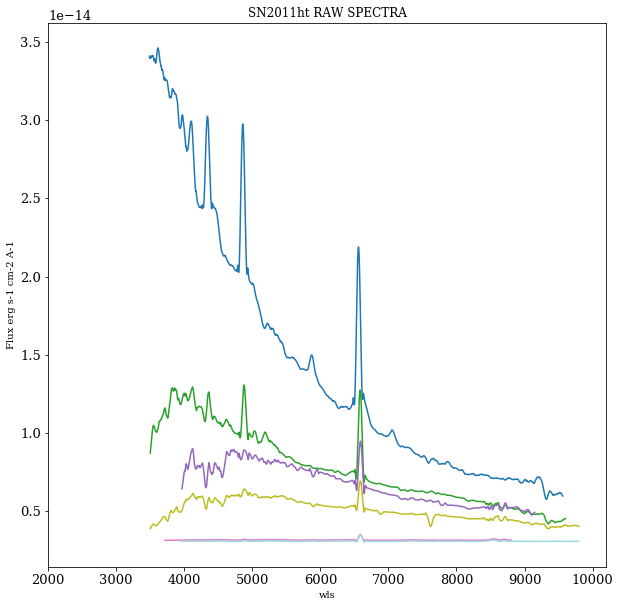

In [25]:
plot_all_rawspecs(spec_test)

self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-13_06-34-21_MMT_Hectospec_None_0.txt


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ht/2011ht_2011-11-22_15-29-30_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-01-03_16-55-01_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-01-23_09-55-03_MMT_Hectospec_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-13_06-34-21_MMT_Hectospec_None_0.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-02-29_19-23-09_APO-3.5m_DIS_None.txt
self.spec_file /spec_smoothed//SN2011ht/2011ht_2012-03-02_14-58-02_APO-3.5m_DIS_None.txt


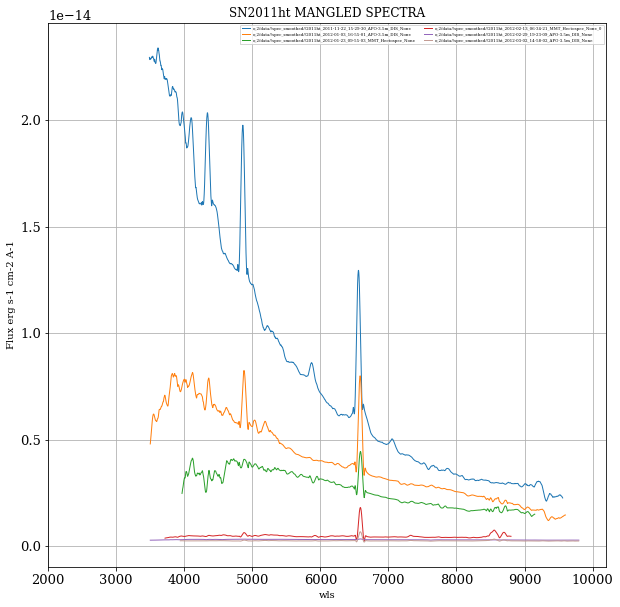

In [26]:
plot_all_mangledspecs(spec_test)

Choose one spec_file from this list:
5
self.spec_file /spec_smoothed//SN2012au/SN2012au_2012-03-27_00-00-00_MMT_MMT-Blue_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2012au/SN_2012au_2012-03-15_12-23-02_Keck1_LRIS_UCB-SNDB_0.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2012au/SN2012au_2012-03-17_00-00-00_FLWO-1.5m_FAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2012au/SN2012au_2012-03-27_00-00-00_MMT_MMT-Blue_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2012au/SN2012au_2012-05-17_00-00-00_FLWO-1.5m_FAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2012au/SN_2012au_2012-06-16_08-34-04_Keck1_LRIS_UCB-SNDB_0.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


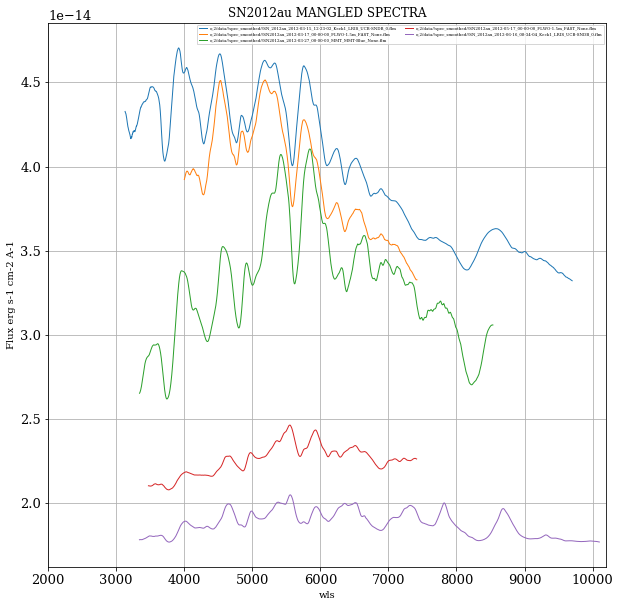

Choose one spec_file from this list:
25
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-01_00-00-00_HCT-2m_HFOSC_None.dat
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-17_00-00-00_SALT_HRS-SALT_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-17_21-57-08_TNG_DOLORES_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-18_00-00-00_HET_HET-LRS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-19_08-04-39_FTN_FLOYDS-N_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-20_00-00-00_Other_Other_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-22_00-00-00_FTN_FLOYDS-N_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-24_00-00-00_FTN_FLOYDS-N_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-25_00-00-00_HCT-2m_HFOSC_None.dat
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-26_00-00-00_HET_HET-LRS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-27_03-51-05_APO-3.5m_DIS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-06-28_00-00-00_HCT-2m_HFOSC_None.dat
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-01_00-00-00_HET_HET-LRS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-01_00-00-00_HCT-2m_HFOSC_None.dat
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-04_00-00-00_HCT-2m_HFOSC_None.dat
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-05_00-00-00_P200_DBSP_iPTF_0.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-09_08-06-31_FTN_FLOYDS-N_iPTF_3.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-11_00-00-00_Keck2_DEIMOS_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-21_22-18-05_NOT_ALFOSC_iPTF.ascii
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-07-23_00-00-00_HCT-2m_HFOSC_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-08-02_10-19-56_FTS_FLOYDS-S_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-08-04_00-00-00_P200_DBSP_iPTF.flm
self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-08-06_00-00-00_HCT-2m_HFOSC_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-08-08_09-58-52_FTS_FLOYDS-S_iPTF_0.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-09-04_00-00-00_P200_DBSP_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//iPTF13bvn/iPTF13bvn_2013-09-09_06-18-09_Keck1_LRIS_iPTF.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


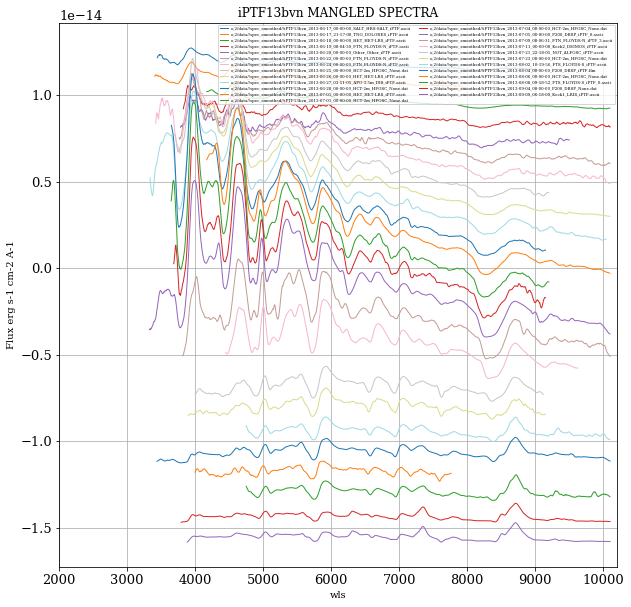

Choose one spec_file from this list:
14
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-13_04-07-24_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-03-22_00-00-00_Lick-3m_KAST_iPTF.flm
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-03-23_02-24-00_TNG_DOLORES_None.dat
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-03-24_19-12-00_Lijiang-2.4m_YFOSC_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-03-28_19-12-00_Lijiang-2.4m_YFOSC_None.dat
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-03-30_16-48-00_Lijiang-2.4m_YFOSC_None.dat
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-02_03-57-37_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-06_03-49-35_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-13_04-07-24_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-16_14-24-00_Lijiang-2.4m_YFOSC_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-19_01-19-28_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.ascii


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-04-22_14-24-00_Lijiang-2.4m_YFOSC_None.dat
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-05-25_16-48-00_Lijiang-2.4m_YFOSC_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars


self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-06-11_12-00-00_Lijiang-2.4m_YFOSC_None.dat
self.spec_file /spec_smoothed//SN2013am/SN2013am_2013-12-27_06-39-50_ESO-NTT_EFOSC2-NTT_PESSTO-SSDR.dat


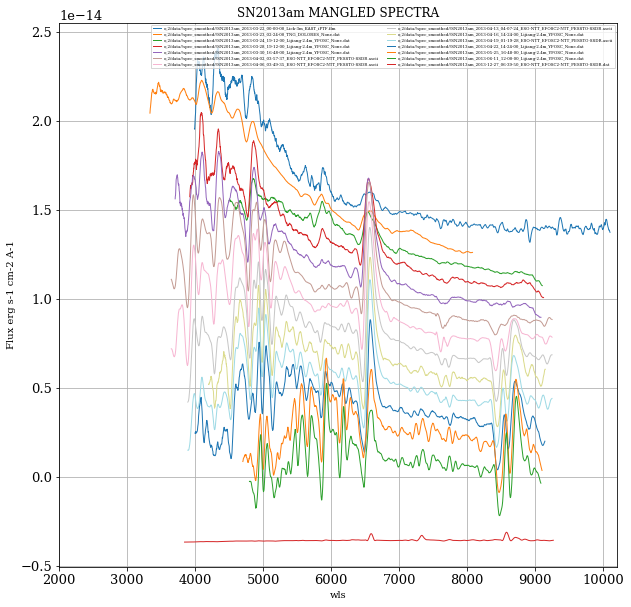

Choose one spec_file from this list:
13
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-26_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-07-29_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-02_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-06_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-08_00-00-00_SALT_RSS_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-16_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-21_00-00-00_SOAR_Goodman_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-26_00-00-00_SALT_RSS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-08-29_00-00-00_SALT_RSS_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-09-20_00-00-00_Magellan-Baade_IMACS_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/george/kernels.py:95: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-09-30_00-00-00_Magellan-Clay_LDSS-3_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-10-18_00-00-00_ESO-NTT_EFOSC2-NTT_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-11-16_00-00-00_SOAR_Goodman_None.flm
self.spec_file /spec_smoothed//SN2011ei/2011ei_2011-11-18_00-00-00_Magellan-Baade_IMACS_None.flm


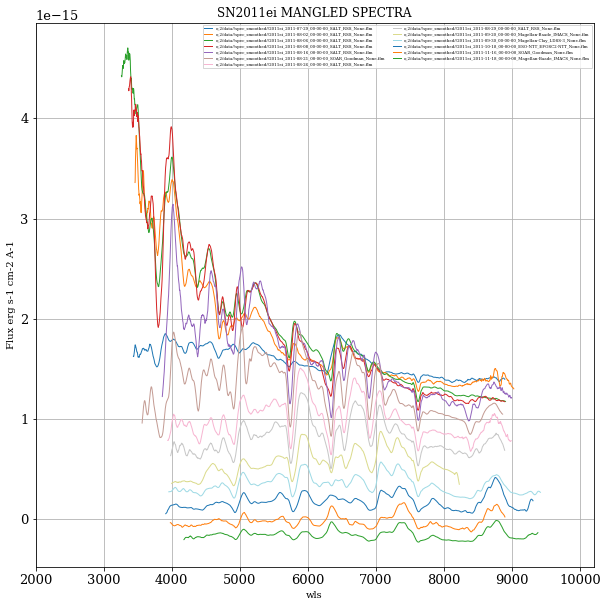

Choose one spec_file from this list:
24
self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-14_00-00-00_Keck1_LRIS_None.flm
self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-01-31_16-39-56_Wise1m_FOSC_None.ASC


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-01_00-00-00_HST_STIS_None.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/2002ap_2002-02-02_00-00-00_Wise1m_FOSC_SUSPECT.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/2002ap_2002-02-03_00-00-00_Wise1m_FOSC_SUSPECT.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-06_02-38-24_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-07_02-09-36_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-08_01-55-12_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-09_02-38-24_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/2002ap_2002-02-10_00-00-00_Wise1m_FOSC_SUSPECT.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-11_00-00-00_Lick-3m_KAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-12_02-52-48_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-13_02-24-00_FLWO-1.5m_FAST_CfA-Stripped.flm
self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-14_00-00-00_Keck1_LRIS_None.flm
self.spec_file /spec_smoothed//SN2002ap/2002ap_2002-02-17_00-00-00_Wise1m_FOSC_SUSPECT.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-20_02-09-36_FLWO-1.5m_FAST_CfA-Stripped.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/2002ap_2002-02-24_00-00-00_Wise1m_FOSC_SUSPECT.dat


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-02-27_17-15-54_Wise1m_FOSC_None.ASC


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-03-07_00-00-00_Keck1_LRIS_None.flm
self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-03-11_00-00-00_Lick-3m_KAST_None.flm
self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-06-08_00-00-00_Lick-3m_KAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-06-17_00-00-00_Lick-3m_KAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:127: RuntimeWarning: invalid value encountered in double_scalars
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:130: RuntimeWarning: invalid value encountered in double_scalars


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-07-11_00-00-00_Lick-3m_KAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-08-09_00-00-00_Lick-3m_KAST_None.flm


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


self.spec_file /spec_smoothed//SN2002ap/SN2002ap_2002-10-08_00-00-00_Keck1_LRIS_None.flm
Impossible to mangle  /Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//SN2002ap/SN2002ap_2002-10-08_00-00-00_Keck1_LRIS_None.flm used [] 
Unused ['Bessell_B', 'Bessell_I', 'Bessell_R', 'Bessell_U', 'Bessell_V']


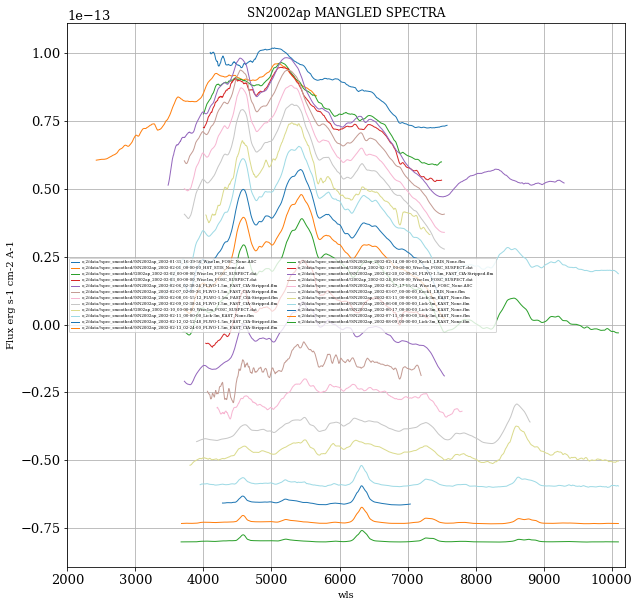

In [8]:
SN_lista=['ASASSN14jb', 'ASASSN15oz', 'SN1993J', 'SN1994I', 'SN1998bw',
       'SN1999dn', 'SN1999em', 'SN2002ap', 'SN2004aw', 'SN2004et',
       'SN2004fe', 'SN2004gq', 'SN2004gt', 'SN2004gv', 'SN2005bf',
       'SN2005cs', 'SN2005hg', 'SN2006T', 'SN2006aa', 'SN2006aj',
       'SN2006ep', 'SN2007Y', 'SN2007gr', 'SN2007od', 'SN2007pk',
       'SN2007ru', 'SN2007uy', 'SN2008D', 'SN2008aq', 'SN2008ax',
       'SN2008bj', 'SN2008bo', 'SN2008fq', 'SN2008in', 'SN2009N',
       'SN2009bb', 'SN2009bw', 'SN2009dd', 'SN2009ib', 'SN2009ip',
       'SN2009iz', 'SN2009jf', 'SN2009kr', 'SN2010al', 'SN2011bm',
       'SN2011dh', 'SN2011ei', 'SN2011fu', 'SN2011hs', 'SN2011ht',
       'SN2012A', 'SN2012ap', 'SN2012au', 'SN2012aw', 'SN2013ab',
       'SN2013am', 'SN2013by', 'SN2013df', 'SN2013ej', 'SN2013fs',
       'SN2013ge', 'SN2014G', 'SN2016X', 'SN2016bkv', 'SN2016gkg',
       'iPTF13bvn', 'SN2013bynouv']

for sn in ['SN2012au', 'iPTF13bvn', 'SN2013am', 'SN2011ei', 'SN2002ap']:
    try:
        spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname=sn,\
                                spec_file=None, verbose=False)
        #plot_all_rawspecs(spec_test)
        plot_all_mangledspecs(spec_test)
    except Exception as e:
        print (sn, e)

In [ ]:
spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname='iPTF13bvn',\
            spec_file= '/Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//iPTF13bvn/iPTF13bvn_-10.75.txt', verbose=False)
raw_spec = spec_test.load_raw_spec()



In [ ]:
spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname='iPTF13bvn',\
            spec_file= '/Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//iPTF13bvn/iPTF13bvn_-10.75.txt', verbose=False)
raw_spec_plusC = spec_test.load_raw_spec()
plt.plot(raw_spec_plusC['wls'], raw_spec_plusC['flux'])
spec_test.break_degeneracy()
raw_spec = spec_test.raw_spec
plt.plot(raw_spec['wls'], raw_spec['flux'])
plt.show()
A= spec_test.mangle_spectrum_function()
plt.plot(spec_test.fitted_phot_dict['eff_wls'],spec_test.fitted_phot_dict['fitted_phot'], 'ok')
plt.plot(raw_spec['wls'], raw_spec['flux'])

In [ ]:
A= spec_test.mangle_spectrum_function()
plt.plot(spec_test.fitted_phot_dict['eff_wls'],spec_test.fitted_phot_dict['fitted_phot'], 'ok')
plt.plot(raw_spec_plusC['wls'], raw_spec_plusC['flux'])


In [ ]:
spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname='SN2008ax',\
            spec_file= '/Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//SN2008ax/SN2008ax_y2008m03d12.txt', verbose=False)
            #spec_file= '/Users/mariavincenzi/PhD/pycoco_2/data//spec_smoothed//SN2008ax/2008ax_-10.48.txt', verbose=False)
raw_spec = spec_test.load_raw_spec()
plt.plot(raw_spec['wls'], raw_spec['flux'])
plt.show()
A= spec_test.mangle_spectrum_function()
plt.plot(spec_test.fitted_phot_dict['eff_wls'],spec_test.fitted_phot_dict['fitted_phot'], 'ok')
plt.plot(raw_spec['wls'], (raw_spec['flux']-min(raw_spec['flux']))*800)

In [ ]:

def make_single_mresiduals_plot(spec_class, T_filt, T_diff, T_discr):
    T_filt = np.array(T_filt)
    T_diff = np.array(T_diff)
    T_discr = np.array(T_discr)

    a=0
    bins= 15#np.arange(-0.15,0.15, 0.03)
    N = len(np.unique(T_filt))
    f = plt.figure(10, figsize = (12,4*N))
    for i in np.unique(T_filt):
        plt.subplot(N, 2, 1+a*2)
        h =plt.hist(T_diff[T_filt==i], facecolor=color_dict[i], alpha=0.3, bins=bins, label=i)
        plt.legend()
        plt.xlabel(r'Difference [mag]')
        plt.vlines(0, 0, max(h[0]))
        plt.subplot(N, 2, 2+a*2)
        h =plt.hist(T_discr[T_filt==i], facecolor=color_dict[i], alpha=0.3, bins=bins, label=i)
        plt.legend()
        plt.vlines(0, 0, max(h[0]))
        plt.xlabel(r'Discrepancy  ( diff / $\sigma$ )')
    
        plt.subplots_adjust(hspace=0.3, wspace=0.1)
        a=a+1
    f.savefig(spec_class.results_mainpath+'mangling_residuals.pdf', bbox_inches='tight')
    plt.close(f)


In [ ]:
selected_list = ['iPTF13bvn',
 'SN1998bw',
 'SN1993J',
 'SN1994I',
 'SN2002ap',
 'SN2004aw',
 'SN2005bf',
 'SN2005cs',
 'SN2007C',
 'SN2006aj',
 'SN2007pk',
 'SN2008ax',
 'SN2008D',
 'SN2009er',
 'SN2009iz',
 'SN2009jf',
 'SN2011bm',
 'SN2011dh',
 'SN2011hs']

In [ ]:

tot_diff=[]
tot_discr=[]
tot_filt=[]
tot_tgt=[]


for tgt in selected_list:
    spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname=tgt,\
                                spec_file=None, verbose=True)

    t_diff=[]
    t_discr=[]
    t_filt=[]
    spec_list = spec_test.get_spec_list()
    for num_file in range(len(spec_list[:])):
        file = spec_list[num_file]
        new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=spec_test.snname,\
                                spec_file=file, verbose=True)
        new_spec.load_raw_spec()
        result = new_spec.mangle_spectrum_function()
        filt, diff, discr = new_spec.get_diff_FittedMangled_phot()
        for i in range(len(diff)):
            tot_diff.append(diff[i])
            tot_filt.append(filt[i])
            tot_discr.append(discr[i])
            tot_tgt.append(tgt)
            t_diff.append(diff[i])
            t_filt.append(filt[i])
            t_discr.append(discr[i])
    make_single_mresiduals_plot(new_spec, t_filt, t_diff, t_discr)

tot_filt = np.array(tot_filt)
tot_diff = np.array(tot_diff)
tot_discr = np.array(tot_discr)
tot_tgt = np.array(tot_tgt)



In [ ]:
len(tot_tgt)

In [ ]:
a=0
bins= 15#np.arange(-0.15,0.15, 0.03)
N = len(np.unique(tot_filt))
fig = plt.figure(1, figsize = (12,4*N))
for i in np.unique(tot_filt):
    plt.subplot(N, 2, 1+a*2)
    h =plt.hist(tot_diff[tot_filt==i], facecolor=color_dict[i], alpha=0.3, bins=bins, label=i)
    plt.legend()
    plt.xlabel(r'Difference [mag]')
    plt.vlines(0, 0, max(h[0]))
    plt.subplot(N, 2, 2+a*2)
    h =plt.hist(tot_discr[tot_filt==i], facecolor=color_dict[i], alpha=0.3, bins=bins, label=i)
    plt.legend()
    plt.vlines([0], 0, max(h[0]))
    plt.vlines([-1,1], 0, max(h[0]), linestyle='--')
    plt.xlabel(r'Discrepancy  ( diff / $\sigma$ )')

    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    a=a+1
fig.savefig('/Users/mariavincenzi/PhD/pycoco_2/data/results_template/mangling_residuals_tenobj.pdf', bbox_inches='tight')



In [ ]:
spec_test.results_mainpath

In [ ]:
#for file in spec_test.get_spec_list():
#    new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname='SN1993J',\
#                                spec_file=file, verbose=True)
#    new_spec.load_raw_spec()
#    new_spec.mangle_spectrum_function()
#


In [ ]:
file='data/spec/SN1998S/SN1998S_-13.9.txt'
new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname='SN1998S',\
                                spec_file=file, verbose=True)
new_spec.load_raw_spec()

In [ ]:
plt.plot(new_spec.raw_spec['wls'], new_spec.raw_spec['flux'])
#plt.errorbar(new_spec.fitted_phot_dict['eff_wls'],\
#             new_spec.fitted_phot_dict['fitted_phot'],\
#             yerr=new_spec.fitted_phot_dict['fitted_phot_err'], linestyle='None', marker='o')
print (len(new_spec.raw_spec['wls']))

In [ ]:
new_spec.mangle_spectrum_function()

In [ ]:
new_spec.mangled_spec

In [ ]:
new_spec.fitted_phot_dict

In [ ]:
new_spec.magled_photometry_dict

In [ ]:
#[2.24731630e-15 3.15501040e-19 6.25306686e-19 2.83279158e-17] 
#[7.96902107e-17 1.08369387e-20 2.40190026e-20 1.02037801e-18]

In [ ]:
full_wls= new_spec.raw_spec['wls']
norm_wls = np.median(full_wls)
full_wls_normed = full_wls/norm_wls
wls_eff=[4413.30691417, 8027.2601124, 6576.87328507, 5512.10390774]
wls_eff_normed = np.array(wls_eff)/norm_wls


ratios= [2.24731630e-15, 3.15501040e-19, 6.25306686e-19, 2.83279158e-17] 
ratios_err= [7.96902107e-17, 1.08369387e-20, 2.40190026e-20, 1.02037801e-18]
norm = np.median(ratios)
ratios_normed = (np.array(ratios)/norm)
ratios_err_normed = (np.array(ratios_err))


def ll(p):
    gp.set_parameter_vector(p)
    return -gp.lnlikelihood(ratios, quiet=False)#
def grad_ll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(ratios, quiet=False)
        
k= np.var(ratios_normed)*Matern32Kernel(0.2)
 
wls_eff_normedT = np.atleast_2d(wls_eff_normed).T

gp = george.GP(k)
gp.compute(wls_eff_normedT, (ratios_err_normed))
p0=gp.get_parameter_vector()

#results = opt.minimize(ll, p0, jac=grad_ll)
print (np.exp(p0), np.exp(gp.get_parameter_vector()))
gp.set_parameter_vector(p0)

mu, cov = gp.predict(ratios_normed, full_wls_normed)
std = np.sqrt(np.diag(cov))


new_spec_raw = new_spec.raw_spec['flux']*norm*(mu)


plt.errorbar(wls_eff_normed, ratios_normed, yerr=ratios_err_normed, mfc='m', marker='o', linestyle='None')
plt.errorbar(full_wls_normed, mu)
plt.fill_between(full_wls_normed, mu-std, mu+std, alpha=0.3)

plt.ylabel('Fitted Photometry / Raw Photometry')
plt.xlabel('Effective wvl')
#plt.ylim(0.8,1.2)

In [ ]:
plt.errorbar(wls_eff, ratios, yerr=ratios_err, mfc='m', marker='o', linestyle='None')
plt.errorbar(full_wls, norm*(mu))
plt.fill_between(full_wls, norm*(mu-std), norm*(mu+std), alpha=0.3)

plt.ylabel('Fitted Photometry / Raw Photometry')
plt.xlabel('Effective wvl')
#plt.ylim(0.8,1.2)

In [ ]:
plt.plot(new_spec.raw_spec['wls'], new_spec_raw)
#plt.yscale('log')
#plt.ylim(10**-18,10**-10)

In [ ]:
plt.plot(spec_test.raw_spec['wls'], 100*spec_test.raw_spec['flux'])
plt.errorbar(spec_test.fitted_phot_dict['eff_wls'],\
             spec_test.fitted_phot_dict['fitted_phot'],\
             yerr=spec_test.fitted_phot_dict['fitted_phot_err'], linestyle='None', marker='o')



In [ ]:
np.array([a for a in zip(spec_test.mangled_spec['wls'], spec_test.mangled_spec['flux'])],\
         dtype=[('wls', '<f8'), ('flux', '<f8')])

In [ ]:
spec_test.raw_spec

In [ ]:
from scipy import interpolate

filt='swift_UVW1'
filt_transm = np.genfromtxt(spec_test.main_path+'filters/%s.dat'%filt,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux'])
#val=spec_test.phot4mangling['%s_fitflux'%filt].values

In [ ]:
filt_transm_interp_func1 = interpolate.InterpolatedUnivariateSpline(filt_transm['wls'], filt_transm['flux'])#, kind='slinear')
filt_transm_interp_func2 = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')

cut_spec = [(spec_test.raw_spec['wls']>min(filt_transm['wls']))&\
 (spec_test.raw_spec['wls']<max(filt_transm['wls']))]
cut_raw_spec = spec_test.raw_spec[cut_spec]
filt_transm_interp1 = filt_transm_interp_func1(cut_raw_spec['wls'])
filt_transm_interp2 = filt_transm_interp_func2(cut_raw_spec['wls'])

In [ ]:
#int1 = scipy.integrate.trapz(filt_transm_interp1*cut_raw_spec['flux'], cut_raw_spec['wls'])/scipy.integrate.trapz(filt_transm_interp1, cut_raw_spec['wls'])
#int2 = scipy.integrate.trapz(filt_transm_interp2*cut_raw_spec['flux'], cut_raw_spec['wls'])/scipy.integrate.trapz(filt_transm_interp2, cut_raw_spec['wls'])
lam_eff = (scipy.integrate.trapz(filt_transm['flux']*filt_transm['wls'], filt_transm['wls'])/\
            scipy.integrate.trapz(filt_transm['flux'], filt_transm['wls']))
#print (filt, val/int1, val/int2)
print (lam_eff)

In [ ]:
plt.plot(filt_transm['wls'], filt_transm['flux'], 'og')
plt.plot(cut_raw_spec['wls'], filt_transm_interp1)
plt.plot(cut_raw_spec['wls'], filt_transm_interp2)


In [ ]:
for file in spec_test.get_spec_list():
    test = SingleSpectrumClass( main_path=DATALC_PATH, snname='SN2005bf',spec_file=file)
    test.load_raw_spec()
    print (len(test.raw_spec['wls']))



In [ ]:
#BessellB 4371.341789719794 [87.64754018]
#BessellI 7991.266516672154 [85.88028319]
#BessellR 6491.715547771806 [88.13772216]
#BessellV 5477.697299227442 [83.76459384]
#SDSS_g 4668.767705805916 [99.52384667]
#SDSS_i 7477.315120919141 [86.45975599]
#SDSS_r 6158.016699776863 [92.19163501]
#
#BessellB 4413.306914172489 [87.64754018]
#BessellI 8027.26011239853 [85.88028319]
#BessellR 6576.873285065187 [88.13772216]
#BessellV 5512.103907737096 [83.76459384]
#SDSS_g 4717.602697175877 [99.52384667]
#SDSS_i 7506.236796491473 [86.45975599]
#SDSS_r 6186.802820978737 [92.19163501]
#Need extention


In [ ]:
full_wls= spec_test.raw_spec['wls'][::2]
norm_wls = np.median(full_wls)
full_wls_normed = full_wls/norm_wls
wls_eff_normed = np.array(wls_eff)/norm_wls

norm = np.median(ratios)
ratios_normed = np.array(ratios)/norm
ratios_err_normed = np.array(ratios_err)/norm


def ll(p):
    gp.set_parameter_vector(p)
    return -gp.lnlikelihood(ratios, quiet=False)#
def grad_ll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(ratios, quiet=False)
        
k= Matern32Kernel(0.05)
 
wls_eff_normedT = np.atleast_2d(wls_eff_normed).T

gp = george.GP(k)
gp.compute(wls_eff_normedT, (ratios_err_normed))
p0=gp.get_parameter_vector()

results = opt.minimize(ll, p0, jac=grad_ll)
#print (np.exp(p0), np.exp(gp.get_parameter_vector()))
#gp.set_parameter_vector(p0)

mu, cov = gp.predict(ratios_normed, full_wls_normed)
std = np.sqrt(np.diag(cov))

mu_full = np.interp(spec_test.raw_spec['wls'], spec_test.raw_spec['wls'][::2], mu)

new_spec_raw = spec_test.raw_spec['flux']*norm*(mu_full)


plt.errorbar(wls_eff_normed, ratios_normed, yerr=ratios_err_normed, mfc='m', marker='o', linestyle='None')
plt.errorbar(full_wls_normed, mu)
plt.fill_between(full_wls_normed, mu-std, mu+std, alpha=0.3)

plt.ylabel('Fitted Photometry / Raw Photometry')
plt.xlabel('Effective wvl')
#plt.ylim(0.8,1.2)

In [ ]:
mu_full = np.interp(spec_test.raw_spec['wls'], spec_test.raw_spec['wls'][::2], mu)



In [ ]:
plt.plot(spec_test.raw_spec['wls'], mu_full, '.k')
plt.plot(spec_test.raw_spec['wls'][::2], mu, '.r')



In [ ]:
plt.errorbar(wls_eff, ratios, yerr=ratios_err, mfc='m', marker='o', linestyle='None')
plt.errorbar(full_wls, norm*(mu))
plt.fill_between(full_wls, norm*((mu)-std), norm*((mu)+std), alpha=0.3)


In [ ]:

mangled_spec_flux = spec_test.raw_spec['flux']*norm*(mu+1.)
plt.plot(spec_test.raw_spec['wls'], mangled_spec_flux)

for filt in spec_test.avail_filters:

    filt_transm = np.genfromtxt(spec_test.main_path+'filters/%s.dat'%filt,\
                                         dtype=None, encoding="utf-8", names=['wls', 'flux'])
    lam_eff = calc_lam_eff(filt_transm['wls'], filt_transm['flux']) 
    fitted_phot = spec_test.phot4mangling['%s_fitflux'%filt].values
    fitted_phot_err = spec_test.phot4mangling['%s_fitfluxerr'%filt].values

    filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
    cut_spec = [(spec_test.raw_spec['wls']>min(filt_transm['wls']))&\
     (spec_test.raw_spec['wls']<max(filt_transm['wls']))]
    cut_mangled_spec_wls = spec_test.raw_spec['wls'][cut_spec]
    cut_mangled_spec_flux = mangled_spec_flux[cut_spec]
    
    filt_transm_interp = filt_transm_interp_func(cut_mangled_spec_wls)
    mangled_phot = scipy.integrate.trapz(filt_transm_interp*cut_mangled_spec_flux, cut_mangled_spec_wls)/\
                 scipy.integrate.trapz(filt_transm_interp, cut_mangled_spec_wls)

    if (lam_eff<max(spec_test.raw_spec['wls']))&(lam_eff>min(spec_test.raw_spec['wls'])):
        print (filt, lam_eff, fitted_phot/mangled_phot)
        fitted_phot_list.append(fitted_phot[0])
        plt.plot(lam_eff, mangled_phot, 'oc', label='mangled_phot')
        plt.errorbar(lam_eff, fitted_phot, yerr=fitted_phot_err, mfc='m', marker='o',ecolor='m', linestyle='None', label='fitted_phot')
        plt.plot(cut_mangled_spec_wls, filt_transm_interp*10**-15)
    else: print ('Need extention')
plt.title('Mangled')

In [ ]:
snname='iPTF13bvn'
snfactory_path = '/Users/mariavincenzi/PhD/SIM_pycoco/SNF-0203-ALLEG2a-13bvn/'
templ_snf_ptf = [f for f in os.listdir(snfactory_path) if (os.path.isfile(os.path.join(snfactory_path, f)))\
                &('.fits' in f)]

In [ ]:
snf_peak_ptf= np.array(['13_184_045_003_2_666_800_02-03_001.fits',
       '13_184_045_003_4_666_800_02-03_001.fits']) #20.11

#snf_peak_ptf=np.array(['13_201_044_003_2_666_800_02-03_001.fits',
# '13_201_044_003_4_666_800_02-03_001.fits'])

snf_peak_ptf=np.array(['13_191_058_003_2_666_800_02-03_001.fits',
       '13_191_058_003_4_666_800_02-03_001.fits']) #8.16

In [ ]:
spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname='iPTF13bvn',\
                                spec_file='data/spec/iPTF13bvn/iPTF13bvn_8.16.txt', verbose=True)

In [ ]:
spec_test.load_raw_spec()

In [ ]:
spec_test.load_manglingfile()

In [ ]:
spec_test.mangle_spectrum_function()

In [ ]:
spec_test.magled_photometry_dict

In [ ]:
snf_peak_ptf_R = fits.open(snfactory_path+ snf_peak_ptf[0])
snf_peak_ptf_B = fits.open(snfactory_path+ snf_peak_ptf[1])

figure=plt.figure(1, figsize=(14,5))
wlsB = (np.arange(snf_peak_ptf_B[0].header['NAXIS1'])) * \
snf_peak_ptf_B[0].header['CDELT1'] + snf_peak_ptf_B[0].header['CRVAL1']
plt.plot(wlsB, snf_peak_ptf_B[0].data, color='grey', lw=0.5, label='SNF')
wlsR = (np.arange(snf_peak_ptf_R[0].header['NAXIS1'])) * \
snf_peak_ptf_R[0].header['CDELT1'] + snf_peak_ptf_R[0].header['CRVAL1']
plt.plot(wlsR, snf_peak_ptf_R[0].data, color='k', lw=0.5, label='SNfactory')#, label='SNF_Rchannel @%s mjd'%str(mjd_fixed))

wls_snf = np.concatenate([wlsB, wlsR])
flux_snf = np.concatenate([snf_peak_ptf_B[0].data, snf_peak_ptf_R[0].data])



plt.plot(spec_test.raw_spec['wls'], spec_test.mangled_spec['flux'], color='g', lw=0.5, label='My Mangled')#, label='SNF_Rchannel @%s mjd'%str(mjd_fixed))
#plt.plot(spec_test.raw_spec['wls'], spec_test.mangling_mask*10**-17)
#plt.plot(spec_test.raw_spec['wls'], spec_test.raw_spec['flux']*190., color='r', lw=0.5)#, label='SNF_Rchannel @%s mjd'%str(mjd_fixed))

plt.plot(spec_test.fitted_phot_dict['eff_wls'], spec_test.fitted_phot_dict['fitted_phot'], '.k')
plt.plot(spec_test.fitted_phot_dict['eff_wls'], spec_test.magled_photometry_dict['fitted_phot'], 'or')


def band_flux_general(filter_name, wls, flux):
    filt_transm = np.genfromtxt(spec_test.main_path+'filters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
    lam_eff = calc_lam_eff(filt_transm['wls'], filt_transm['flux']) 
    filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
    cut_spec = [(wls>min(filt_transm['wls']))&(wls<max(filt_transm['wls']))]
    filt_transm_interp = filt_transm_interp_func(wls[cut_spec])
    raw_phot = scipy.integrate.trapz(filt_transm_interp*flux[cut_spec], wls[cut_spec])/\
                 scipy.integrate.trapz(filt_transm_interp, wls[cut_spec])
    plt.plot(filt_transm['wls'], filt_transm['flux']*0.5*10**-15)
    return lam_eff, raw_phot

snf_phot =[]
snf_lmb =[]


for f in spec_test.avail_filters[:-1]:
    a,b = band_flux_general(f, wls_snf, flux_snf)
    snf_lmb.append(a)
    snf_phot.append(b)
#plt.plot(snf_lmb, snf_phot, 'ob')

plt.xlabel('wls')
plt.ylabel('calibrated flux')
plt.legend()
plt.title('iPTF13bvn')
plt.xlim(3000,10000)
    

In [ ]:
figure=plt.figure(1, figsize=(14,5))

plt.plot(spec_test.raw_spec['wls'], spec_test.mangling_mask, '.k')


In [ ]:
full_list = ['iPTF13bvn', 'SN1993J', 'SN1994I', 'SN1996cb', 'SN1998A', 'SN1998bw', 'SN1998S', 'SN1999dn', 'SN1999el',
             'SN2000cb', 'SN2000eo', 'SN2002ap', 'SN2002gd', 'SN2003bg', 'SN2003jd', 'SN2004A', 'SN2004aw',
             'SN2005bf', 'SN2005cp', 'SN2005cs', 'SN2005db', 'SN2005hg', 'SN2005kd', 'SN2006aj', 'SN2006ca', 
             'SN2006el', 'SN2006V', 'SN2006X', 'SN2007av', 'SN2007bf', 'SN2007C', 'SN2007ct', 'SN2007cu',
             'SN2007gr', 'SN2007pk', 'SN2007T', 'SN2007uy', 'SN2007Y', 'SN2008aj', 'SN2008aq', 'SN2008ax',
             'SN2008B', 'SN2008bj', 'SN2008bo', 'SN2008bx', 'SN2008D', 'SN2008fq', 'SN2009bb', 'SN2009dd', 
             'SN2009E', 'SN2009er', 'SN2009iz', 'SN2009jf', 'SN2009mg', 'SN2010al', 'SN2010bq', 'SN2011bm', 
             'SN2011dh', 'SN2011ei', 'SN2011fu', 'SN2011hs', 'SN2012ap', 'SN2012ec', 'SN2013am', 'SN2013ej',
             'SN2013ge']

In [ ]:
no_spec=['SN2005db',
 'SN2005kd',
 'SN2006ca',
 'SN2006X',
 'SN2007av',
 'SN2007bf',
 'SN2007ct',
 'SN2007cu',
 'SN2007T',
 'SN2008aj',
 'SN2008B',
 'SN2008bj',
 'SN2008bx',
 'SN2009dd',
 'SN2010bq']

In [ ]:
color_dict = {'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'deepskyblue'}

In [ ]:
for tgt in full_list:
    if tgt not in no_spec:
        spec_test = SingleSpectrumClass(main_path=DATALC_PATH, snname=tgt,\
                                spec_file=None, verbose=True)
        print ('######', tgt, len(spec_test.get_spec_list()))
        for file in spec_test.get_spec_list():
            new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname=tgt,\
                                    spec_file=file, verbose=True)
            try:
                new_spec.load_raw_spec()
                new_spec.mangle_spectrum_function()
            except Exception as e: 
                print (e)




In [ ]:
for tgt in full_list[:]:
    if tgt not in no_spec:
        spec = SingleSpectrumClass(main_path=DATALC_PATH, snname=tgt,\
                                spec_file=None, verbose=True)
        try:
            plot_all_rawspecs(spec)
            plot_all_mangledspecs(spec)
        except Exception as e: 
            print (e)



In [ ]:
spec = SingleSpectrumClass(main_path=DATALC_PATH, snname='SN2005bf',\
                                spec_file=None, verbose=True)
plot_all_mangledspecs(spec)
#
#for file in spec.get_spec_list():
#    new_spec= SingleSpectrumClass(main_path=DATALC_PATH, snname='SN2005cp',\
#                                    spec_file=file, verbose=True)
#    try:
#        new_spec.load_raw_spec()
#        plot_all_mangledspecs(spec)
#    except Exception as e: 
#        print (e)

In [ ]:
spec = SingleSpectrumClass(main_path=DATALC_PATH, snname='SN2005bf',\
                                spec_file=None, verbose=True)
try:
    plot_all_specs(spec)
except Exception as e: 
    print (e)



In [ ]:
new_spec.mangle_spectrum_function()

In [ ]:
full_list[54]

In [ ]:
x=[2,3,4,5]
y=[8,9,10,11]

In [ ]:
plt.plot(x,y, marker='o', mfc=['blue','red','pink','orange'])